<img src="./logo_UNSAM.jpg" align="right" width="150" /> 

# TS8: Filtrado digital lineal de ECG

**Alumnas:** María Victoria Poric y Agustina Rocío Paolini Rosso  
**Carrera:** Ingeniería Biomédica    
**Materia:** Análisis y Procesamiento de Señales    
**Fecha:** Noviembre 2025 

#### Consigna
Usando el archivo `ecg.mat` que contiene un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, diseñe y aplique los filtros digitales necesarios para mitigar las siguientes fuentes de contaminación:  
- Ruido causado por el movimiento de los electrodos (Alta frecuencia).
- Ruido muscular (Alta frecuencia).
- Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia). 

a) Establezca una plantilla de diseño para los filtros digitales que necesitará para que la señal de ECG se asemeje a los latidos promedio en cuanto a suavidad de los trazos y nivel isoeléctrico nulo. 

b) ¿Cómo obtuvo dichos valores? Describa el procedimiento para establecer los valores de la plantilla. 

c) Diseñe al menos dos filtros FIR y dos IIR para su comparación. Verifique que la respuesta en frecuencia responda a la plantilla de diseño. 

d) Evalúe el rendimiento de los filtros que haya diseñado: Verifique que filtra las señales interferentes. Verifique que es inocuo en las zonas donde no hay interferentes.

## Introducción
La señal electrocardiográfica (ECG) es un registro eléctrico de la actividad del corazón que proporciona información fundamental sobre el funcionamiento cardíaco. Durante la adquisición de la señal, es común que aparezcan diversas fuentes de interferencia, como el movimiento de los electrodos, el ruido muscular o la deriva de la línea de base inducida por la respiración. Estas contaminaciones pueden dificultar la interpretación de los complejos QRS y de los latidos en general, por lo que resulta esencial aplicar técnicas de filtrado digital que permitan mejorar la calidad de la señal y preservar su morfología fisiológica.

El diseño de filtros digitales permite atenuar selectivamente las frecuencias indeseadas mientras se conserva la información relevante de la señal ECG. Entre los principales tipos de filtros se encuentran los Filtros FIR (Finite Impulse Response) y los Filtros IIR (Infinite Impulse Response).

Los filtros FIR poseen respuesta finita al impulso, lo que garantiza estabilidad inherente y la posibilidad de diseñar filtros con fase lineal, preservando la forma de los complejos QRS. Entre los métodos más utilizados para su diseño se encuentran el método de ventanas, los cuadrados mínimos y el método Parks–McClellan o Remez, que permite obtener un filtrado equiripple optimizado.

Por otro lado, los filtros IIR presentan respuesta infinita al impulso, lo que les permite lograr una mayor selectividad con órdenes más bajos en comparación con los FIR. Su diseño requiere atención para garantizar la estabilidad y minimizar la distorsión de fase. Las aproximaciones más comunes incluyen Butterworth, que proporciona máxima planicidad en la banda pasante; Chebyshev, que ofrece mayor atenuación en la banda de rechazo a cambio de ondulación controlada; y Cauer (elíptico), que optimiza la transición entre banda pasante y de rechazo.

El presente trabajo tiene como objetivo diseñar y comparar filtros FIR e IIR que atenúen las interferencias presentes en un registro de ECG obtenido durante una prueba de esfuerzo. Se busca que la señal filtrada conserve la morfología de los latidos, los niveles isoeléctricos se mantengan estables y se reduzcan las interferencias de alta y baja frecuencia, evaluando la eficacia de cada tipo de filtro mediante análisis de la señal filtrada en regiones con y sin ruido.

## Análisis y resultados
En primer lugar, para que la señal de ECG adquiera la suavidad y estabilidad propias de un latido promedio, se definió una plantilla de diseño basada en las características espectrales reales del electrocardiograma y en pruebas prácticas realizadas en clase. La frecuencia de muestreo utilizada fue de `1000 Hz`, a partir de la cual se determinaron las bandas de paso y de stop necesarias.

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
from pytc2.sistemas_lineales import plot_plantilla
import scipy.io as sio

# Plantilla de diseño
fs = 1000 # Hz
ws1 = 0.1 # Hz
wp1 = 0.8 # Hz
wp2 = 35 # Hz
ws2 = 40 # Hz
WP = [wp1, wp2] # comienzo y fin de la banda de paso
WS = [ws1, ws2] # comienzo y fin de la banda de stop (corresponde a la atenuacion minima y maxima) -- mas grande que la de paso
 
nyq_frec = fs/2
ripple = 1/2 # dB
atenuacion = 40/2 # dB
  
# plantilla normalizada a Nyquist en dB
frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ])/nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
 
# convertimos a veces para las funciones de diseño
gains = 10**(gains/20)

La banda de paso se fijó entre `0.8` y `35 Hz`, ya que en ese rango se concentra el contenido fisiológicamente relevante del ECG, incluyendo las ondas P, QRS y T, mientras que por debajo de `0.5 Hz` predominan artefactos de respiración y movimientos corporales, y por encima de `40 Hz` aparece principalmente ruido muscular (EMG). Para asegurar un comportamiento suave del filtro y evitar la distorsión de las ondas cardíacas, se estableció un ripple dentro de la banda de paso, lo cual permite mantener la forma de las señales sin introducir ondulaciones apreciables. En las bandas de stop, ubicadas por debajo de `0.1 Hz` y por encima de `40 Hz`, se fijó una atenuación suficiente para rechazar tanto el baseline drift como el ruido de alta frecuencia sin requerir filtros de orden excesivo. Se dejó además una breve transición entre 35 y 40 Hz para estabilizar el diseño y evitar cambios abruptos en la respuesta en frecuencia.

Los valores adoptados surgieron de la combinación entre criterios teóricos y pruebas prácticas. Durante las actividades de clase se ensayaron distintas configuraciones hasta encontrar las frecuencias límite y los niveles de atenuación que mejor preservaban la morfología del ECG. La elección de las bandas se basó en el conocimiento de que la información clínica del electrocardiograma se concentra entre 1 y 30–35 Hz, mientras que los artefactos dominan fuera de ese rango. El ripple y la atenuación se ajustaron para lograr un compromiso adecuado entre fidelidad de la señal y rechazo del ruido. 

Una vez definidos estos parámetros, todas las frecuencias se normalizaron dividiéndolas por la frecuencia de Nyquist, y la plantilla se expresó primero en dB y luego en escala lineal, dado que funciones de diseño como `firwin2`, `remez` y `fir2` requieren trabajar con ganancias lineales. Con esta plantilla fue posible diseñar filtros capaces de limpiar un ECG contaminado con ruido, permitiendo recuperar un trazo suave, estable y con nivel isoeléctrico adecuado.

Asimismo, se cargó el ECG con ruido para este trabajo.

In [49]:
# Lectura de ECG
mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = mat_struct['ecg_lead'].flatten()
cant_muestras = len(ecg_one_lead)

Luego, se diseñaron los filtros IIR necesarios para analizar el comportamiento de distintas aproximaciones de módulo. Estos filtros, a diferencia de los FIR, son recursivos y presentan una fase inherentemente no lineal, por lo que resulta especialmente útil observar tanto la magnitud como la fase y el retardo de grupo.

In [50]:
#Diseño cuatro filtros IIR (aproximaciones de módulo):

f_aprox_butter = 'butter'
f_aprox_ch1 = 'cheby1'
f_aprox_ch2 = 'cheby2'
f_aprox_cauer = 'cauer'

mi_sos_butter = sig.iirdesign(wp=WP, ws=WS, gpass=ripple, gstop=atenuacion, analog=False, ftype=f_aprox_butter, output='sos', fs=fs)
mi_sos_cheby1 = sig.iirdesign(wp=WP, ws=WS, gpass=ripple, gstop=atenuacion, analog=False, ftype=f_aprox_ch1, output='sos', fs=fs)
mi_sos_cheby2 = sig.iirdesign(wp=WP, ws=WS, gpass=ripple, gstop=atenuacion, analog=False, ftype=f_aprox_ch2, output='sos', fs=fs)
mi_sos_cauer = sig.iirdesign(wp=WP, ws=WS, gpass=ripple, gstop=atenuacion, analog=False, ftype=f_aprox_cauer, output='sos', fs=fs)

Para simplificar su implementación se utilizó la función `sig.iirdesign` de la librería `scipy`, que permite obtener directamente filtros en formato SOS (Second Order Sections) a partir de los valores de plantilla previamente establecidos. Con estos parámetros se generaron cuatro diseños correspondientes a las aproximaciones Butterworth, Chebyshev tipo I, Chebyshev tipo II y Cauer (elíptico).

Una vez obtenidas las estructuras en SOS, se calculó su respuesta en frecuencia mediante `sig.freqz_sos`, utilizando un muestreo logarítmico de frecuencias que mejora la resolución en las zonas de baja frecuencia, donde el ECG presenta la mayor parte de su contenido útil. A partir de la fase calculada se determinó el retardo de grupo mediante la expresión
$$
\tau_g = -\,\frac{d \phi(\omega)}{d \omega}
$$

lo que permitió visualizar la variación temporal introducida por cada filtro.

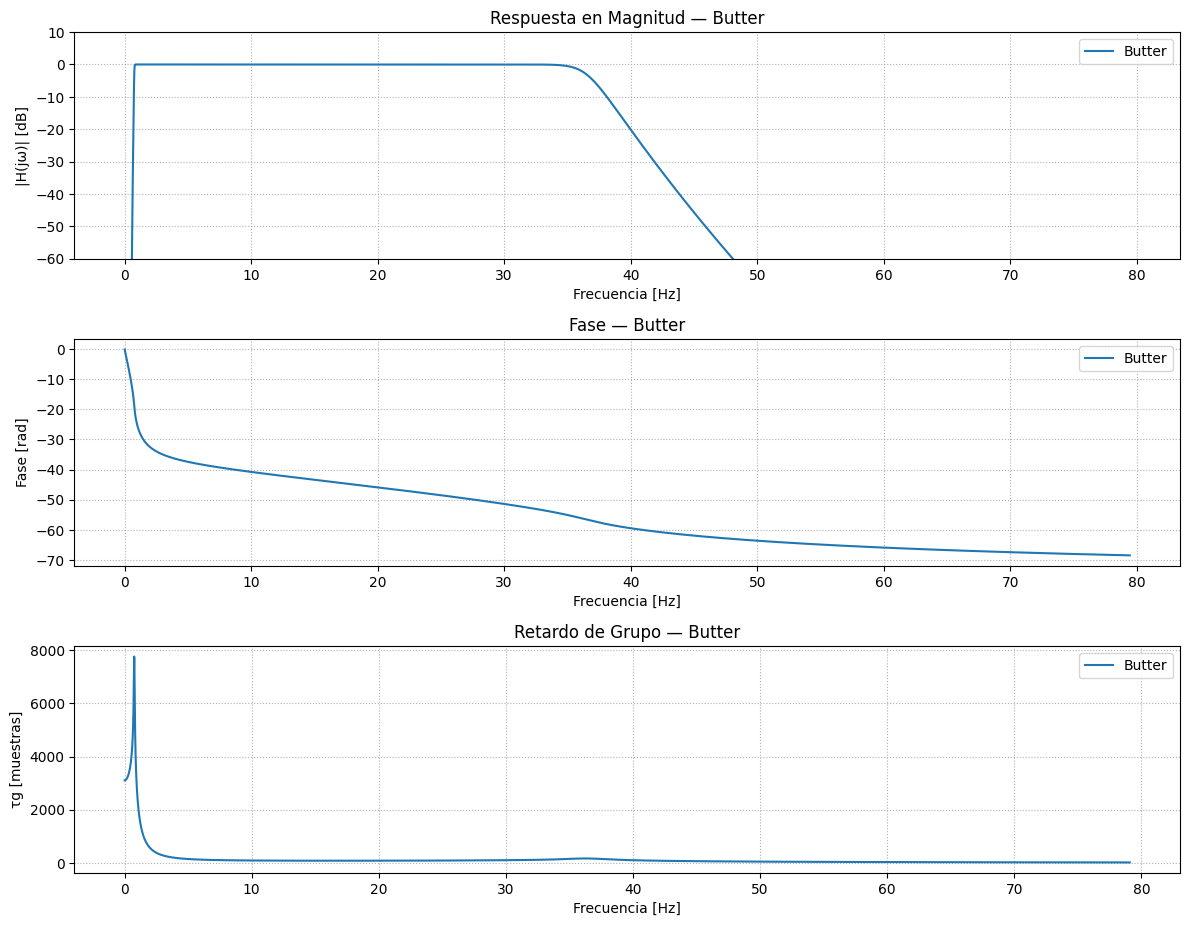

In [51]:
def plot_sos(sos, fs, name="Filtro IIR",
             filter_type=None, fpass=None, ripple=None,
             fstop=None, attenuation=None):
 
    # RESPUESTA EN FRECUENCIA
    w, h = sig.freqz_sos(sos=sos, fs=fs, worN=np.logspace(-2, 1.9, 2000))

    # FASE Y RETARDO DE GRUPO
    phase = np.unwrap(np.angle(h))
    w_rad = w / (fs/2) * np.pi
    gd = -np.diff(phase) / np.diff(w_rad)

    # GRÁFICAS
    plt.figure(figsize=(12, 12))

    # MAGNITUD
    plt.subplot(4, 1, 1)
    plt.plot(w, 20*np.log10(np.abs(h)), label=name)
    plt.title(f'Respuesta en Magnitud — {name}')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('|H(jω)| [dB]')
    plt.ylim(-60, 10)
    plt.grid(True, ls=':')
    plt.legend()

    # FASE
    plt.subplot(4, 1, 2)
    plt.plot(w, phase, label=name)
    plt.title(f'Fase — {name}')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Fase [rad]')
    plt.grid(True, ls=':')
    plt.legend()

    # RETARDO DE GRUPO
    plt.subplot(4, 1, 3)
    plt.plot(w[:-1], gd, label=name)
    plt.title(f'Retardo de Grupo — {name}')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('τg [muestras]')
    plt.grid(True, ls=':')
    plt.legend()

    plt.tight_layout()
    plt.show()

    
plot_sos(sos=mi_sos_butter, fs=fs, name='Butter', filter_type='bandpass', fpass=WP, ripple=ripple*2, fstop=WS, attenuation=atenuacion*2)

La respuesta del filtro Butterworth mostrada en las gráficas confirma el comportamiento teórico esperado para esta aproximación. En la primera figura, correspondiente al módulo, se aprecia claramente una banda de paso completamente plana desde bajas frecuencias hasta alrededor de 35 Hz, sin ondulaciones ni variaciones locales. Esta máxima planitud es característica del diseño Butterworth y garantiza que el contenido útil del ECG no sufra modificaciones dentro de ese rango. A partir de aproximadamente 40 Hz comienza la zona de transición, donde la magnitud desciende de manera suave y monotónica hasta alcanzar niveles de fuerte atenuación en la banda de rechazo. El punto donde el módulo cae 3 dB respecto del nivel de la banda de paso coincide con la frecuencia de corte del filtro, lo cual también se observa visualmente en la pendiente que inicia alrededor de dicha región. Tal como es propio de esta aproximación, la transición es amplia y progresiva, sin cambios abruptos.

La segunda gráfica, correspondiente a la fase, muestra un comportamiento claramente no lineal. La fase decrece de forma continua con la frecuencia, inicialmente de manera más pronunciada en los primeros hertz y luego con una pendiente más suave. Esta no linealidad implica que distintas componentes frecuenciales del ECG experimentan diferentes retrasos temporales, una consecuencia inherente al carácter recursivo del filtro.

El retardo de grupo, representado en la tercera figura, refuerza esta observación. Se evidencia un pico elevado en frecuencias muy bajas, lo cual indica que esas componentes sufren un retardo temporal mayor. A medida que la frecuencia aumenta, el retardo disminuye rápidamente y se estabiliza en valores mucho menores dentro de la banda de paso. Sin embargo, cerca de la zona de transición vuelve a observarse un incremento, lo que coincide con la variación de la pendiente de la fase en esa región. Este comportamiento es típico de los filtros IIR y, en particular, del Butterworth debido a su transición gradual.


En cuanto al filtro Chebyshev de tipo I:

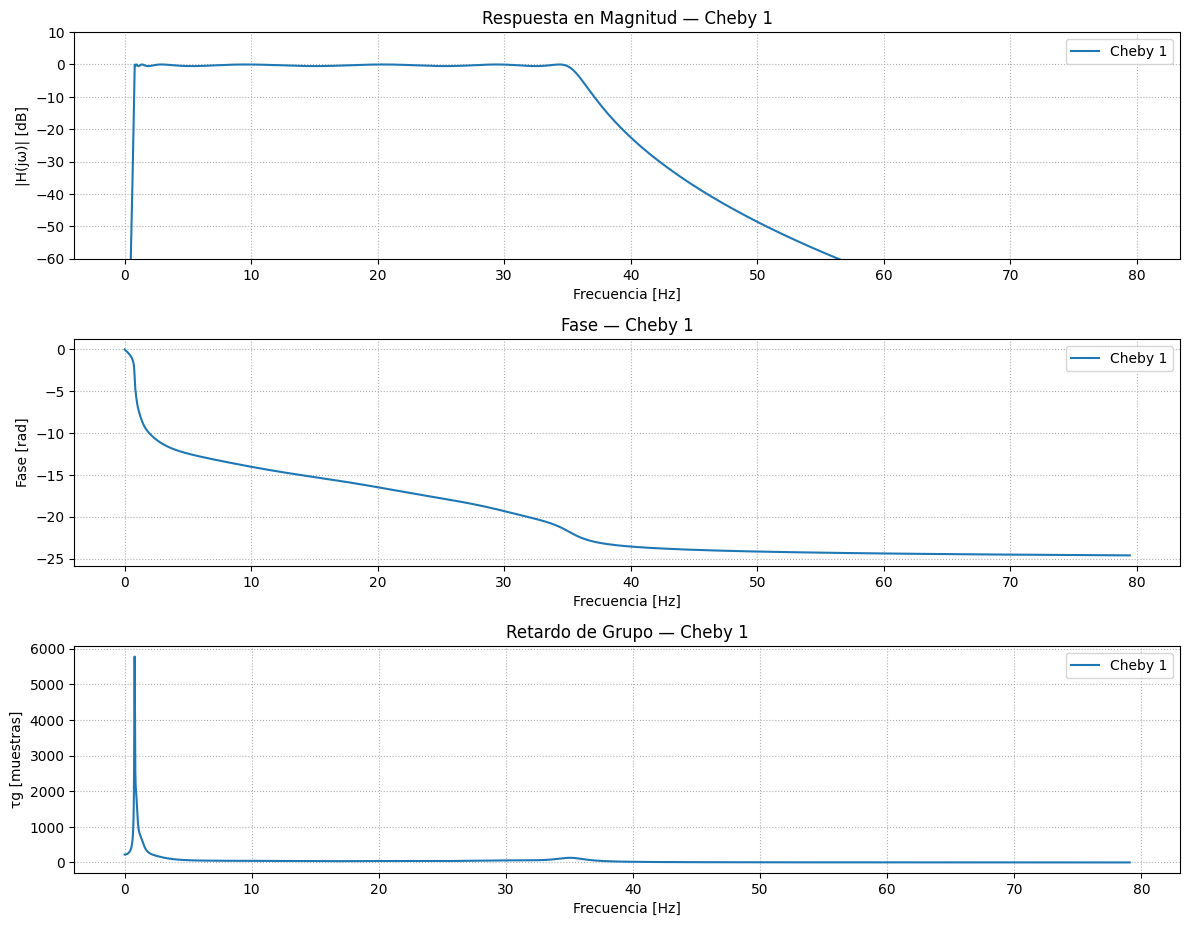

In [52]:
plot_sos(sos=mi_sos_cheby1, fs=fs, name='Cheby 1', filter_type='bandpass', fpass=WP, ripple=ripple*2, fstop=WS, attenuation=atenuacion*2)

La respuesta en magnitud del filtro Chebyshev tipo I muestra claramente la ondulación característica dentro de la banda de paso: el módulo oscila con una amplitud pico a pico constante, evidenciando el comportamiento equiripple propio de esta aproximación. Una vez superada la frecuencia de banda de paso, que determina su frecuencia de corte, la magnitud desciende de manera monotónica y con una pendiente más pronunciada que la del Butterworth, lo que confirma su transición más abrupta. 

La fase, al igual que en otros IIR, presenta un comportamiento no lineal que decrece progresivamente con la frecuencia. El retardo de grupo refuerza esta característica, mostrando valores elevados en bajas frecuencias que luego disminuyen rápidamente y se estabilizan en la banda de paso, sin grandes variaciones más allá de la zona de transición. En conjunto, las tres gráficas reflejan la mayor selectividad del Chebyshev I respecto del Butterworth, a costa de introducir ondulaciones en la banda útil y una fase no lineal dependiente de la frecuencia.


En cuanto al filtro Chebyshev de tipo II:

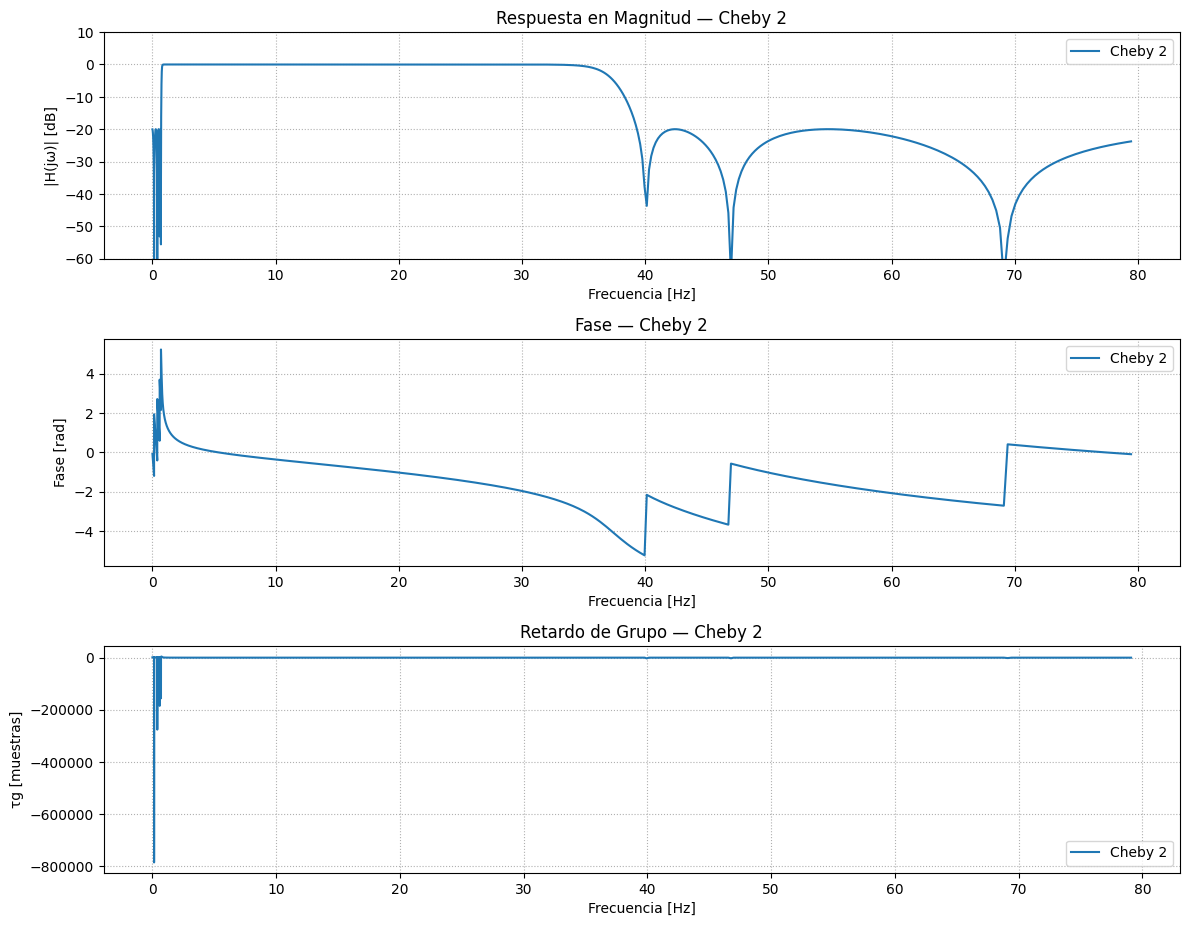

In [53]:
plot_sos(sos=mi_sos_cheby2, fs=fs, name='Cheby 2', filter_type='bandpass', fpass=WP, ripple=ripple*2, fstop=WS, attenuation=atenuacion*2)

La respuesta en módulo del filtro Chebyshev tipo II se distingue por una banda de paso esencialmente plana y monotónica, muy similar a la obtenida con un filtro Butterworth, ya que en esta región no presenta ondulaciones. Sin embargo, su comportamiento cambia notablemente en la banda de rechazo, donde aparecen oscilaciones equiripple que se mantienen dentro de los límites de atenuación. Estas ondulaciones son una consecuencia directa del diseño del filtro y permiten obtener una transición más abrupta entre la banda de paso y la de rechazo en comparación con un Butterworth del mismo orden. En este tipo de filtro, la frecuencia de corte se define a partir de la frecuencia de banda de rechazo, dado que es allí donde se controla la ondulación.

La fase del filtro refleja la complejidad introducida por las oscilaciones en la banda de rechazo. Aunque en frecuencias bajas su comportamiento es relativamente suave, a medida que la frecuencia aumenta comienzan a observarse cambios más bruscos, incluyendo saltos y variaciones pronunciadas que son característicos de los filtros con ceros en el eje imaginario, como ocurre en el Chebyshev II. Estas irregularidades se intensifican cerca de las frecuencias donde el módulo presenta los nulos asociados a los ceros del filtro.

El retardo de grupo muestra un comportamiento marcado por la presencia de ceros en la banda de rechazo. Al inicio, el retardo toma valores muy negativos debido a los fuertes cambios de fase cerca de las frecuencias bajas, donde la pendiente de la fase es particularmente pronunciada. A medida que la frecuencia aumenta, estas variaciones extremas disminuyen y el retardo se estabiliza, acercándose progresivamente a cero en la mayor parte de la banda.

Finalmente, para el filtro Cauer o elíptico:

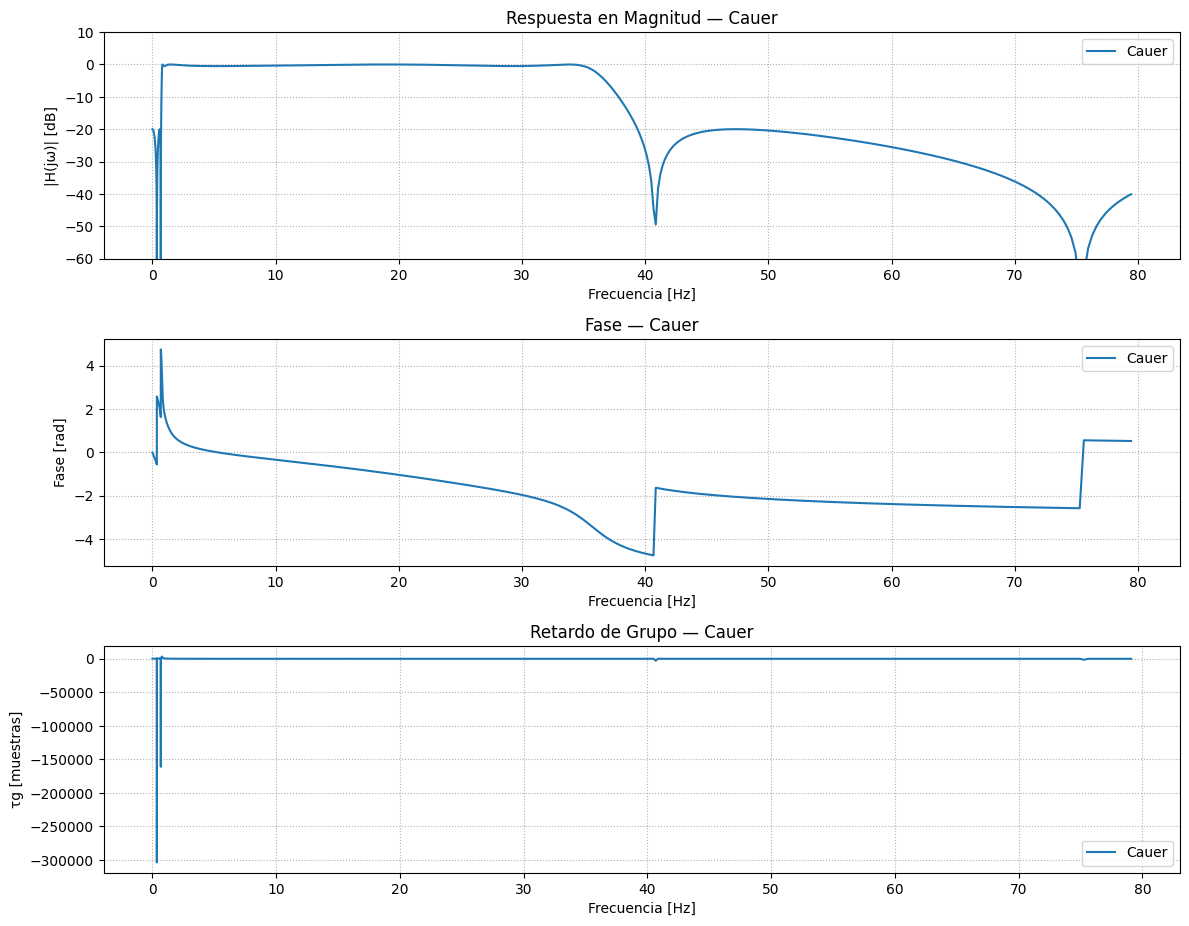

In [54]:
plot_sos(sos=mi_sos_cauer, fs=fs, name='Cauer', filter_type='bandpass', fpass=WP, ripple=ripple*2, fstop=WS, attenuation=atenuacion*2)

En el caso del filtro Cauer o elíptico, la respuesta en magnitud muestra el comportamiento más selectivo de todos. En la banda de paso aparece una ondulación equiripple, con oscilaciones de amplitud constante que reflejan la relajación de la planitud a cambio de una transición mucho más abrupta. En la banda de rechazo también se observan oscilaciones equiripple, producidas por los ceros que caracterizan a este tipo de filtro y que permiten alcanzar niveles altos de atenuación en un rango estrecho de frecuencias. La frecuencia de corte queda determinada por el límite de la banda de paso, y la pendiente de transición es la más pronunciada entre las familias estudiadas, lo que permite separar de forma más eficiente las bandas deseada y no deseada para un mismo orden.

La fase presenta un comportamiento no lineal, con cambios bruscos en correspondencia con los ceros y polos que definen su respuesta elíptica. Esto genera variaciones significativas en la pendiente de fase y discontinuidades aparentes debidas al salto de $\pi$ por el desfasaje acumulado. El retardo de grupo refleja esta complejidad: en frecuencias bajas aparecen valores muy negativos y de gran magnitud, resultado de las fuertes variaciones de fase; luego, al alejarse de esa región crítica, el retardo tiende a estabilizarse y se aproxima a valores próximos a cero en la mayor parte del espectro. Este comportamiento evidencia la elevada no linealidad en fase típica de los filtros elípticos.


Luego, se diseñaron tres filtros FIR: uno por el método de ventanas, otro mediante cuadrados mínimos y el último empleando el método de Parks-McClellan.

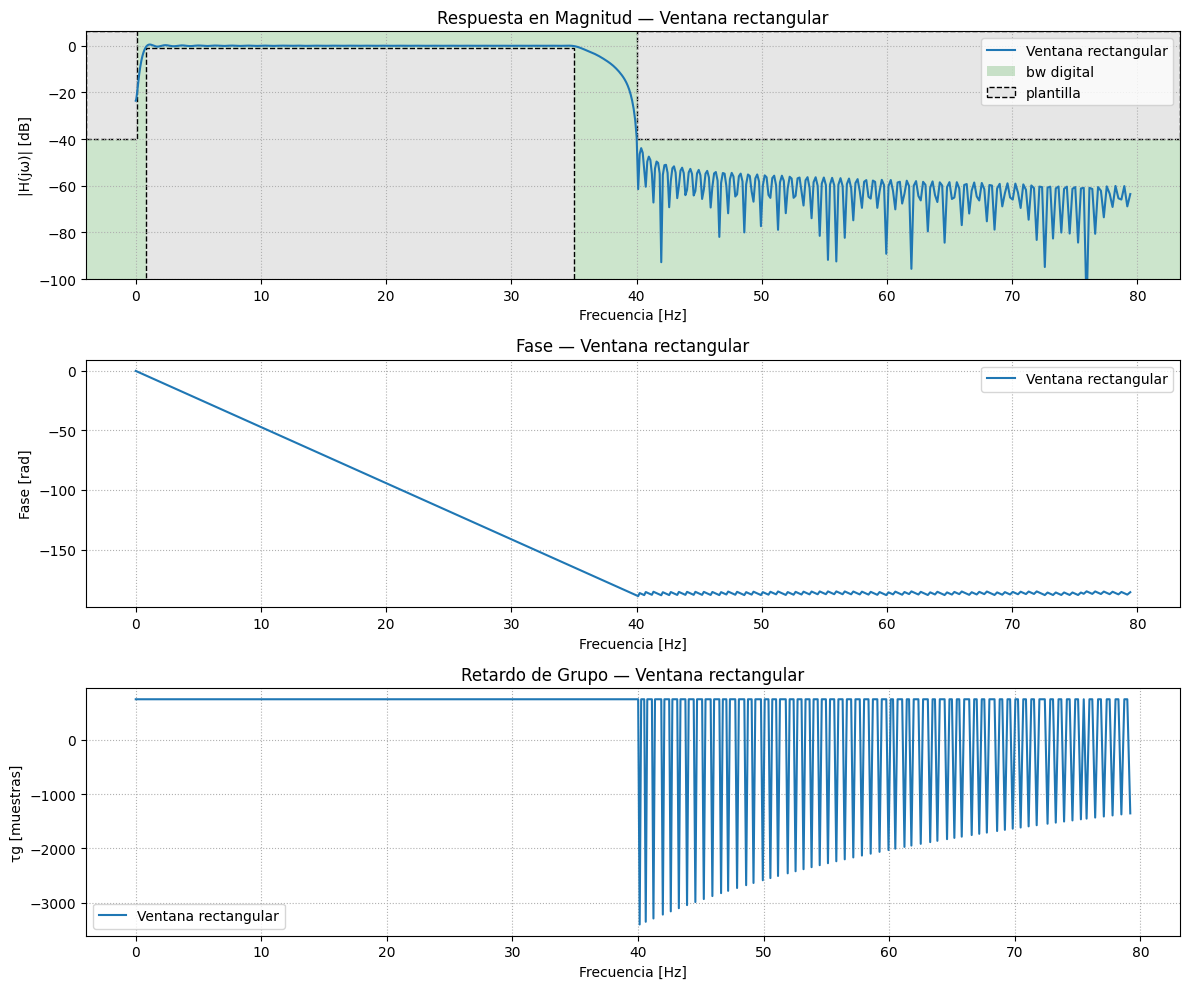

In [55]:
def plot_plantilla(filter_type = 'lowpass', fpass = 0.25, ripple = 0.5, fstop = 0.6, attenuation = 40, fs = 2 ):
    
    # para sobreimprimir la plantilla de diseño de un filtro
    
    xmin, xmax, ymin, ymax = plt.axis()
    
    # banda de paso digital
    plt.fill([xmin, xmin, fs/2, fs/2],   [ymin, ymax, ymax, ymin], 'g', alpha= 0.2, lw=1, label = 'bw digital') # pass
    
    if filter_type == 'lowpass':
    
        fstop_start = fstop
        fstop_end = xmax
        
        fpass_start = xmin
        fpass_end   = fpass
    
        plt.fill( [fstop_start, fstop_end,   fstop_end, fstop_start], [-attenuation, -attenuation, ymax, ymax], '0.9', lw=1, ls = '--', ec = 'k', label = 'plantilla') # stop
        plt.fill( [fpass_start, fpass_start, fpass_end, fpass_end],   [ymin, -ripple, -ripple, ymin], '0.9', lw=1, ls = '--', ec = 'k') # pass
    
    elif filter_type == 'highpass':
    
        fstop_start = xmin
        fstop_end = fstop 
        
        fpass_start = fpass
        fpass_end   = xmax
    
        plt.fill( [fstop_start, fstop_end,   fstop_end, fstop_start], [-attenuation, -attenuation, ymax, ymax], '0.9', lw=1, ls = '--', ec = 'k', label = 'plantilla') # stop
        plt.fill( [fpass_start, fpass_start, fpass_end, fpass_end],   [ymin, -ripple, -ripple, ymin], '0.9', lw=1, ls = '--', ec = 'k') # pass
    
    
    elif filter_type == 'bandpass':
    
        fstop_start = xmin
        fstop_end = fstop[0]
        
        fpass_start = fpass[0]
        fpass_end   = fpass[1]
        
        fstop2_start = fstop[1]
        fstop2_end =  xmax
        
        plt.fill( [fstop_start, fstop_end,   fstop_end, fstop_start], [-attenuation, -attenuation, ymax, ymax], '0.9', lw=1, ls = '--', ec = 'k', label = 'plantilla') # stop
        plt.fill( [fpass_start, fpass_start, fpass_end, fpass_end],   [ymin, -ripple, -ripple, ymin], '0.9', lw=1, ls = '--', ec = 'k') # pass
        plt.fill( [fstop2_start, fstop2_end,   fstop2_end, fstop2_start], [-attenuation, -attenuation, ymax, ymax], '0.9', lw=1, ls = '--', ec = 'k') # stop
        
    elif filter_type == 'bandstop':
    
        fpass_start = xmin
        fpass_end   = fpass[0]
    
        fstop_start = fstop[0]
        fstop_end = fstop[1]
        
        fpass2_start = fpass[1]
        fpass2_end   = xmax
            
        plt.fill([fpass_start, fpass_start, fpass_end, fpass_end],   [ymin, -ripple, -ripple, ymin], '0.9', lw=1, ls = '--', ec = 'k', label = 'plantilla') # pass
        plt.fill([fstop_start, fstop_end,   fstop_end, fstop_start], [-attenuation, -attenuation, ymax, ymax], '0.9', lw=1, ls = '--', ec = 'k') # stop
        plt.fill([fpass2_start, fpass2_start, fpass2_end, fpass2_end],   [ymin, -ripple, -ripple, ymin], '0.9', lw=1, ls = '--', ec = 'k') # pass
    
    
    plt.axis([xmin, xmax, np.max([ymin, -100]), np.max([ymax, 5])])


# Diseño de filtros FIR
frecuencias = np.sort(np.concatenate(((0,fs/2), WP, WS)))  #frecuencia va de cero a Nyquist
deseado = [0,0,1,1,0,0]  #Puntos de mi respuesta, respecto a frecuencias(en 0 va 0, en 0.1 va 0, etc.)

#Método ventana
cant_coef_win = 1501
retardo_win = (cant_coef_win - 1)//2
fir_win_rect = sig.firwin2(numtaps = cant_coef_win, freq = frecuencias, gain = deseado, window='boxcar', nfreqs = 2 * cant_coef_win, fs = fs) #Esto es un filtro tipo 2

#Otro método (cuadrados mínimos)
cant_coef_ls = 999 # cant de coeficientes impar
retardo_ls = (cant_coef_ls - 1)//2
frecuencias_ls = [0, ws1, wp1, wp2, ws2, fs/2]
weights_ls = [3, 0.2, 3]
fir_ls = sig.firls(numtaps=cant_coef_ls,
    bands=frecuencias_ls, desired=deseado, weight=weights_ls, fs=fs)

#Método Remez
cant_coef_rem = 999 # cant de coeficientes impar
retardo_rem = (cant_coef_rem - 1)//2
frecuencias_rem = [0, ws1, wp1, wp2, ws2, fs/2]
deseado_rem = [0, 1, 0]
weights_rem = [20, 1, 20]   # stopband más pesado
fir_rem = sig.remez(numtaps=cant_coef_rem, bands=frecuencias_rem, desired=deseado_rem, weight=weights_rem, fs=fs)

def plot_filtro_fir(b, fs, name="Filtro FIR",
                filter_type=None, fpass=None, ripple=None, 
                fstop=None, attenuation=None):
  
    w, h = sig.freqz(b=b, fs=fs, worN=np.logspace(-2, 1.9, 3000))

    phase = np.unwrap(np.angle(h))
    w_rad = w / (fs/2) * np.pi
    gd = -np.diff(phase) / np.diff(w_rad)

    #   GRÁFICAS
    plt.figure(figsize=(12, 10))

    # === MAGNITUD ===
    plt.subplot(3, 1, 1)
    plt.plot(w, 20*np.log10(np.abs(h)), label=name)
    if filter_type is not None:
        plot_plantilla(filter_type, fpass, ripple, fstop, attenuation, fs)
    plt.title(f'Respuesta en Magnitud — {name}')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('|H(jω)| [dB]')
    plt.grid(True, which='both', ls=':')
    plt.legend()

    # === FASE ===
    plt.subplot(3, 1, 2)
    plt.plot(w, phase, label=name)
    plt.title(f'Fase — {name}')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Fase [rad]')
    plt.grid(True, which='both', ls=':')
    plt.legend()

    # === RETARDO DE GRUPO ===
    plt.subplot(3, 1, 3)
    plt.plot(w[:-1], gd, label=name)
    plt.title(f'Retardo de Grupo — {name}')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('τg [muestras]')
    plt.grid(True, which='both', ls=':')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_filtro_fir(b=fir_win_rect, fs=fs, name='Ventana rectangular', filter_type='bandpass', fpass=WP, ripple=ripple*2, fstop=WS, attenuation=atenuacion*2)

Aclaración: fue necesario incluir la función `plot_plantilla` dado que el código no la llamaba, a pesar de incluir al comienzo la línea:
```python
from pytc2.sistemas_lineales import plot_plantilla
```
En primer lugar, se ordenan las frecuencias porque tanto `firwin2` como `firls` exigen que el vector de bandas esté estrictamente ordenado de menor a mayor. Una vez hecho esto, se diseña el primer FIR mediante el método de ventanas. En este caso, `firwin2` toma la respuesta en frecuencia ideal definida por los puntos (`frecuencias`, `deseado`) y la aproxima con un FIR real aplicando asimilación por ventana.
La cantidad de coeficientes utilizada (`1501`) surge de las pruebas realizadas en clase, eligiendo el valor que mejor cumple la plantilla.
Para un FIR lineal, el retardo está dado por
$$
\tau = \frac{N - 1}{2}
$$
por lo que cada filtro tiene un retardo fijo determinado únicamente por su longitud.

Luego se diseña el filtro mediante cuadrados mínimos (`firls`). Este método minimiza el error cuadrático medio entre la respuesta ideal y la obtenida. La asignación numérica de los pesos demuestra que se privilegia una fuerte atenuación en las bandas de rechazo por sobre tener un ripple perfectamente controlado en la banda de paso: el filtro “prefiere” asegurar la supresión de ruido antes que la planitud exacta en la banda útil.

Finalmente, se diseña el FIR Parks-McClellan usando `remez`, el cual minimiza el error máximo (criterio de Chebyshev), produciendo filtros óptimos en el sentido de equiripple. Se asignan pesos altos en las bandas de stop y un peso más suave en la banda de paso, lo que fuerza una atenuación muy elevada en la banda de rechazo, incluso a costa de una pequeña ondulación de la banda útil.

Para el caso del FIR por ventanas:
- El criterio de diseño consiste en modular o truncar la respuesta al impulso ideal($h_{ideal} [n]$) multiplicándola por una ventana $w[n]$.
- La respuesta $H(\omega)$ es la convolución en frecuencia de $H_{ideal}(\omega)$ y la transformada de Fourier de la ventana $W(\omega)$.
- Presenta ondulación (ripple) no uniforme. Hay una relación inversa fundamental: si el lóbulo principal es más estrecho (transición más rápida), los lóbulos laterales son más altos (menor atenuación)
- El ancho de transición depende de la longitud $N$. El ancho de lóbulo principal de $W(\omega)$ determina $\Delta\omega$. Aumentar $N$ reduce $\Delta\omega$
- La atenuación mínima($\delta_s$) generalmente es fija, determinada por la ventana elegida e independiente de la longitud $N$.

En los gráficos obtenidos para el filtro FIR diseñado mediante una ventana rectangular se observan claramente las características teóricas propias de este método.

En la respuesta en magnitud se aprecia una banda pasante plana hasta aproximadamente $40\,$Hz, seguida de una transición muy abrupta, coherente con 
el estrecho lóbulo principal característico de la ventana rectangular. Sin embargo, esta transición rápida se acompaña de lóbulos laterales de gran 
amplitud en la banda de rechazo, lo que evidencia una atenuación limitada. Estas oscilaciones se extienden a lo largo de la banda eliminada y alcanzan valores cercanos a $-20$ a $-25\,$dB, lo cual coincide con la baja atenuación teórica asociada a esta ventana.

El gráfico de fase presenta una variación lineal en la banda pasante, indicativa de un retardo de grupo aproximadamente constante, pero exhibe 
distorsiones cuando se ingresa en la región de transición y la banda de rechazo. Esto es esperable, ya que la ventana rectangular no garantiza una 
respuesta en fase optimizada.

En el gráfico del retardo de grupo se observa un valor constante hasta alrededor de los $40\,$Hz, seguido de un incremento abrupto y oscilaciones 
considerables en la banda de rechazo. Esta irregularidad es una consecuencia directa de la fuerte ondulación introducida por los lóbulos laterales y de la falta de suavidad en el truncado temporal.

Seguidamente, para el FIR diseñado mediante cuadrados mínimos:

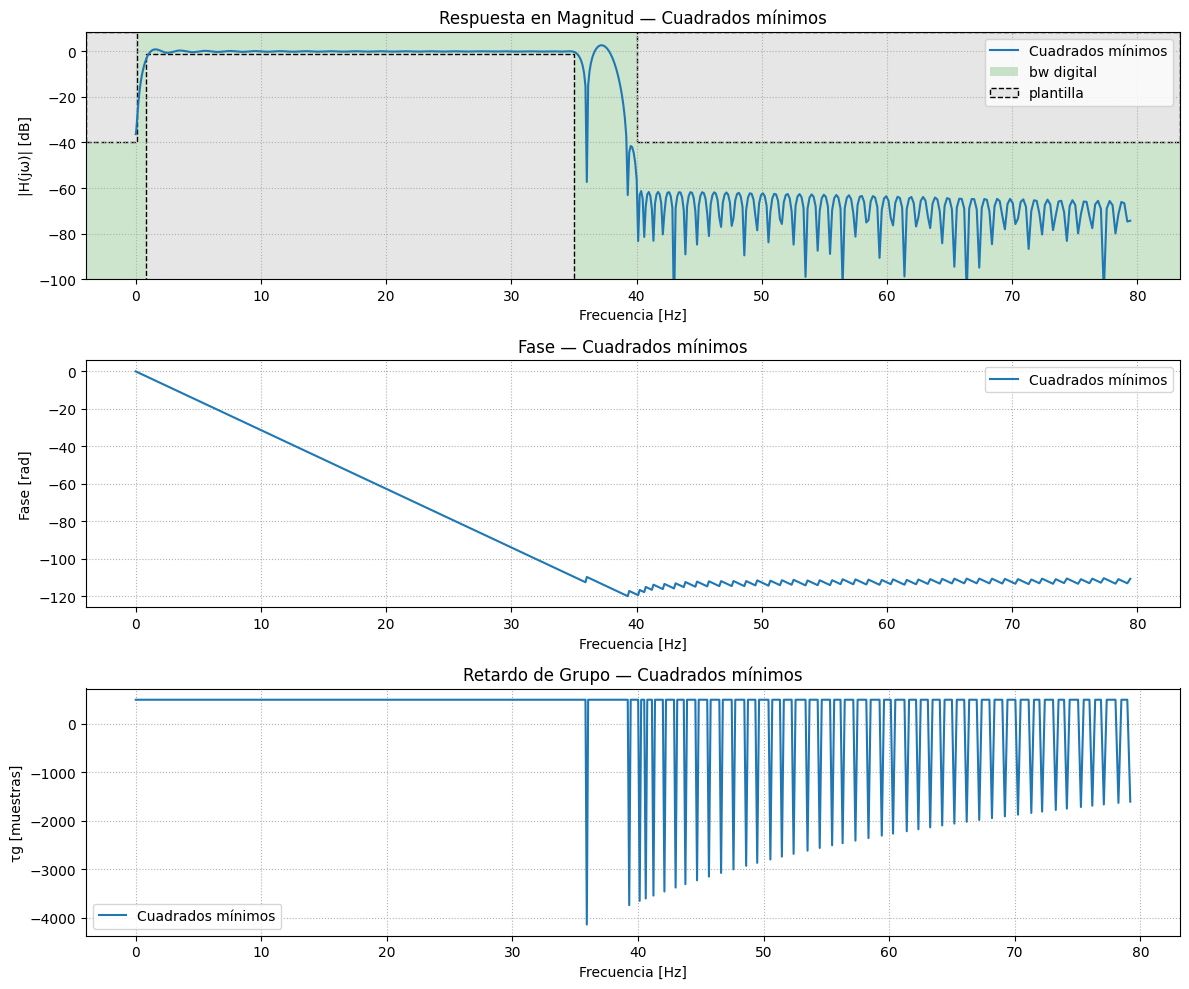

In [56]:
plot_filtro_fir(b=fir_ls, fs=fs, name='Cuadrados mínimos', filter_type='bandpass', fpass=WP, ripple=ripple*2, fstop=WS, attenuation=atenuacion*2)

El criterio de diseño se basa en minimizar el error cuadrático total entre la respuesta obtenida $H(\omega)$ y la respuesta deseada $H_d(\omega)$ a lo largo de las bandas especificadas. El método busca que, en promedio, la energía del error sea mínima, lo cual hace que la respuesta se acerque globalmente a la ideal, aunque no necesariamente con ondulación uniforme.

La forma final del ripple depende directamente de los pesos asignados a cada banda: al aumentar la ponderación en una banda determinada, el algoritmo concentra la minimización del error en esa zona, logrando mayor atenuación o menor ondulación según el objetivo. De esta manera, el filtro puede mantener el ancho de banda y la región de transición deseadas mientras redistribuye el error según la importancia relativa de cada banda. Además, la atenuación mínima en las bandas de rechazo puede ser controlada explícitamente mediante la elección de los pesos, lo que permite priorizar la supresión del ruido o interferencias sin necesidad de aumentar el orden del filtro.

En los gráficos correspondientes al filtro FIR diseñado mediante el método de cuadrados mínimos se observan diferencias importantes respecto del diseño por ventanas. 

En la respuesta en magnitud se aprecia una banda pasante mucho más controlada, con ondulación reducida y una transición más suave en comparación 
con la ventana rectangular. El método de cuadrados mínimos permite distribuir el error en frecuencia de manera óptima en el sentido de mínimos cuadrados, por lo que la ondulación en la banda pasante y la banda de rechazo resulta más uniforme. Si bien la atenuación en la banda eliminada no es tan elevada como la que se obtiene con diseños óptimos tipo Remez, se observa claramente una mejora respecto del caso con ventana rectangular: los lóbulos laterales son significativamente más pequeños y la energía del ripple está mejor repartida.

En la fase se observa un comportamiento aproximadamente lineal en la banda pasante, lo cual es coherente con la estructura FIR del filtro. No obstante, aparecen pequeñas ondulaciones en la zona cercana a la frecuencia de corte y en la banda de rechazo, producto de las irregularidades residuales en la magnitud que introduce la aproximación de mínimos cuadrados.

El retardo de grupo muestra un valor prácticamente constante en la banda pasante, como es esperable en un FIR, seguido de un aumento brusco y 
patrones oscilatorios en la banda eliminada. Estas oscilaciones son menores que las observadas en el diseño por ventana rectangular, lo cual es consistente con la mayor suavidad de la transición y la reducción de ripple obtenida con este método.

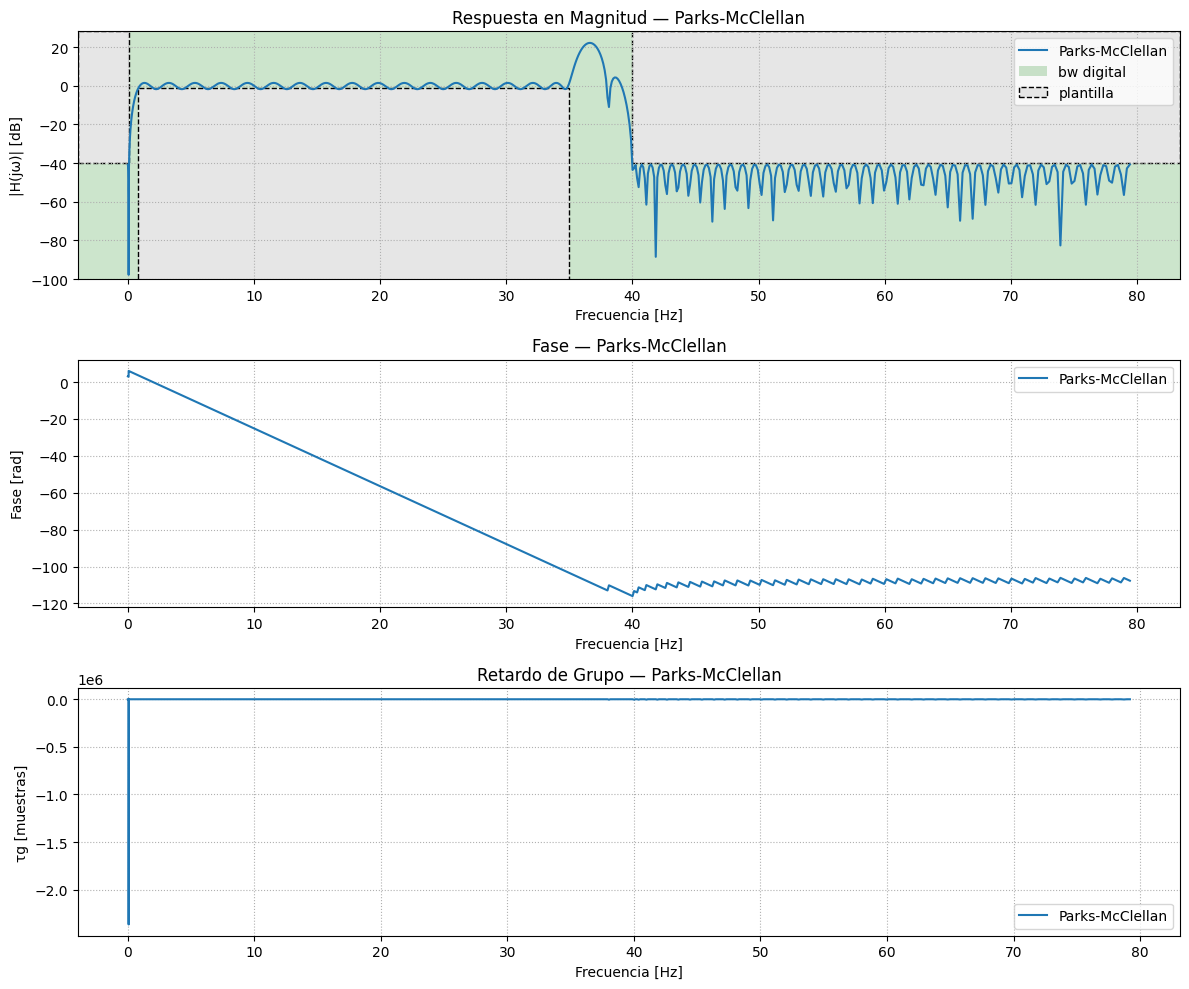

In [57]:
plot_filtro_fir(b=fir_rem, fs=fs, name='Parks-McClellan', filter_type='bandpass', fpass=WP, ripple=ripple*2, fstop=WS, attenuation=atenuacion*2)

Por último, para el FIR de Parks-McClellan:
- El criterio de diseño consiste en minimizar el error máximo ponderado entre $H(\omega)$ y $H_d(\omega)$ en las bandas de interés.
- Presenta equirriple. Todas las ondulaciones en la banda de paso y banda de rechazo son de la misma magnitud.
- Ondulación uniforme, todos los máximos de error son iguales.
- El ancho de transición es el más abrupto (más estrecho) de todos para un orden N dado.
- Cumple exactamente con la $\delta_s$ especificada con el orden más bajo posible

En los gráficos correspondientes al filtro diseñado mediante el algoritmo de Parks-McClellan se evidencia el comportamiento característico de un diseño óptimo en el sentido de la minimización del error máximo (criterio *minimax*). Este método ajusta la respuesta del filtro de modo que las ondulaciones en la banda pasante y en la banda de rechazo sean equioscilantes, lo que se traduce en una distribución óptima del error y en el cumplimiento estricto de las tolerancias impuestas por la plantilla.

En la respuesta en magnitud se observa una banda pasante con ondulación uniforme y limitada al valor especificado, muy inferior a la obtenida con los 
métodos de ventana o mínimos cuadrados. La transición es claramente más rápida y definida, lo cual se debe a que el algoritmo ajusta la localización de ceros y la forma de la respuesta para obtener el menor ancho de banda de transición posible para un orden dado. En la banda de rechazo, la ondulación también es uniforme y alcanza el nivel de atenuación requerido, mostrando el clásico comportamiento equirriple.

En el gráfico de fase se observa una tendencia lineal en la banda pasante, como es esperable en un filtro FIR, aunque con pequeñas irregularidades 
cercanas al borde de la banda debido a la abrupta transición y al ajuste minimax. En la banda eliminada aparecen ondulaciones menores, consecuencia 
directa del patrón equirriple de la magnitud.

El retardo de grupo muestra un valor prácticamente constante en la banda pasante, coherente con la linealidad aproximada de fase, y experimenta 
variaciones bruscas fuera de ella. Estas variaciones se concentran en la zona de transición y reflejan la naturaleza altamente ajustada del diseño. Aun así, el comportamiento en banda pasante es claramente superior al de los métodos anteriores.

A continuación, se filtró la señal de ECG con los filtros diseñados (se muestran las primeras 50000 muestras):

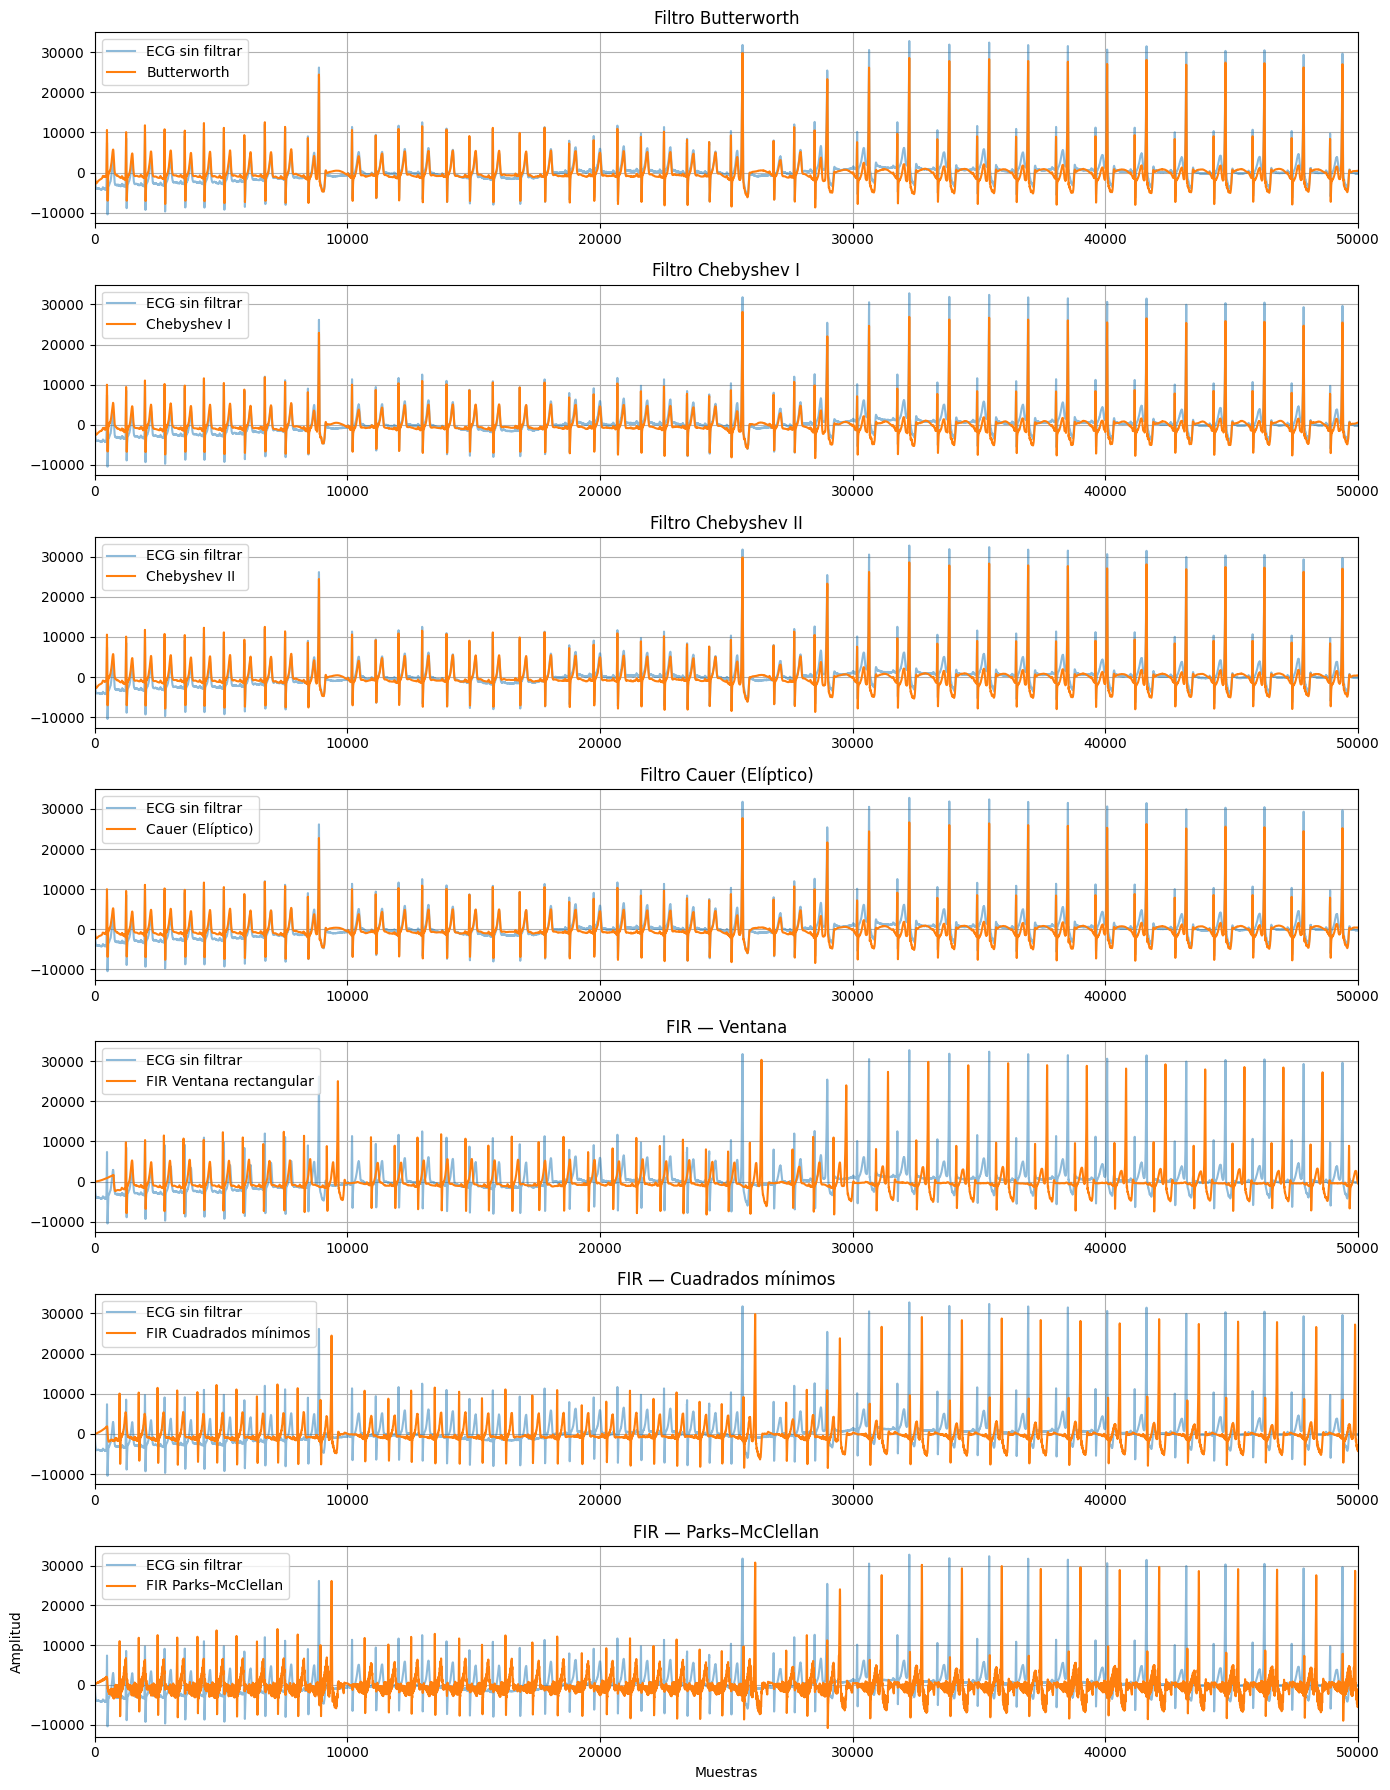

In [58]:
ecg_filt_win = sig.lfilter(b = fir_win_rect, a = 1, x = ecg_one_lead)
ecg_filt_ls = sig.lfilter(b = fir_ls, a = 1, x = ecg_one_lead)
ecg_filt_rem = sig.lfilter(b = fir_rem, a = 1, x = ecg_one_lead)

ecg_filt_butter = sig.sosfiltfilt(mi_sos_butter, ecg_one_lead)
ecg_filt_cheby1 = sig.sosfiltfilt(mi_sos_cheby1, ecg_one_lead)
ecg_filt_cheby2 = sig.sosfiltfilt(mi_sos_cheby2, ecg_one_lead)
ecg_filt_cauer = sig.sosfiltfilt(mi_sos_cauer, ecg_one_lead)


# Cantidad de muestras a mostrar
N = 50000

plt.figure(figsize=(14, 18))

# --- 1. Butterworth ---
plt.subplot(7, 1, 1)
plt.plot(ecg_one_lead[:N], label='ECG sin filtrar', alpha=0.5)
plt.plot(ecg_filt_butter[:N], label='Butterworth')
plt.title('Filtro Butterworth')
plt.legend()
plt.grid()
plt.xlim(0, N)

# --- 2. Chebyshev I ---
plt.subplot(7, 1, 2)
plt.plot(ecg_one_lead[:N], label='ECG sin filtrar', alpha=0.5)
plt.plot(ecg_filt_cheby1[:N], label='Chebyshev I')
plt.title('Filtro Chebyshev I')
plt.legend()
plt.grid()
plt.xlim(0, N)

# --- 3. Chebyshev II ---
plt.subplot(7, 1, 3)
plt.plot(ecg_one_lead[:N], label='ECG sin filtrar', alpha=0.5)
plt.plot(ecg_filt_cheby2[:N], label='Chebyshev II')
plt.title('Filtro Chebyshev II')
plt.legend()
plt.grid()
plt.xlim(0, N)

# --- 4. Cauer / Elíptico ---
plt.subplot(7, 1, 4)
plt.plot(ecg_one_lead[:N], label='ECG sin filtrar', alpha=0.5)
plt.plot(ecg_filt_cauer[:N], label='Cauer (Elíptico)')
plt.title('Filtro Cauer (Elíptico)')
plt.legend()
plt.grid()
plt.xlim(0, N)

# --- 5. FIR por ventana ---
plt.subplot(7, 1, 5)
plt.plot(ecg_one_lead[:N], label='ECG sin filtrar', alpha=0.5)
plt.plot(ecg_filt_win[:N], label='FIR Ventana rectangular')
plt.title('FIR — Ventana')
plt.legend()
plt.grid()
plt.xlim(0, N)

# --- 6. FIR cuadrados mínimos ---
plt.subplot(7, 1, 6)
plt.plot(ecg_one_lead[:N], label='ECG sin filtrar', alpha=0.5)
plt.plot(ecg_filt_ls[:N], label='FIR Cuadrados mínimos')
plt.title('FIR — Cuadrados mínimos')
plt.legend()
plt.grid()
plt.xlim(0, N)

# --- 7. FIR Parks–McClellan ---
plt.subplot(7, 1, 7)
plt.plot(ecg_one_lead[:N], label='ECG sin filtrar', alpha=0.5)
plt.plot(ecg_filt_rem[:N], label='FIR Parks–McClellan')
plt.title('FIR — Parks–McClellan')
plt.legend()
plt.grid()
plt.xlim(0, N)

plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.tight_layout()
plt.show()

En esta sección se comparan las señales de ECG filtradas utilizando los distintos filtros digitales diseñados. En todos los gráficos se muestra la señal original (en azul) superpuesta con la señal filtrada correspondiente (en naranja).

A partir de la inspección visual es posible decir que el complejo QRS es una estructura muy estrecha, abrupta y de alta pendiente, por lo que es especialmente sensible al suavizado y a la distorsión de fase introducidos por los filtros. Además, la señal filtrada mantiene la morfología global del ECG en todos los casos, pero la forma exacta del QRS cambia según la respuesta en magnitud y fase de cada filtro.

En los cuatro casos correspondientes a filtros IIR se advierte que los picos del QRS aparecen ligeramente atenuados y más redondeados en comparación con la señal original. Esto es consistente con la pendiente de magnitud más suave cerca de la frecuencia de corte. Además, los filtros IIR a pesar de no poseer fase lineal, no introducen desplazamiento temporal del QRS, dado que su implementación se realizó mediante la función `sig.sosfiltfilt` que cancela la fase. Esto se refleja en que los picos de la señal filtrada coinciden exactamente con los de la señal original.
El filtro Cauer presenta la mayor atenuación fuera de banda, pero también la mayor posibilidad de ripple y distorsión en la zona del QRS, tal como se observa alrededor de los picos más altos.

El diseño FIR por ventana muestra una ligera demora en la alineación temporal del QRS (debido a la fase aproximadamente lineal), pero muestra ripple evidente en las zonas de la línea base y en los segmentos entre latidos. Este ripple es visible como pequeñas oscilaciones adicionales alrededor de la señal filtrada. La forma del QRS se preserva mejor que con los IIR, aunque presenta una leve pérdida de nitidez debido al ancho de transición relativamente mayor.

El diseño de mínimos cuadrados logra una señal filtrada con menos ripple que la versión por ventanas y con buena preservación de la morfología del QRS.
Los picos mantienen una demora en su alineación temporal, la distorsión en la forma es mínima y se observa un leve suavizado respecto de la señal original.

Finalmente, aunque el método de Parks-McClellan suele optimizar el compromiso entre atenuación y ripple, en este caso se observan oscilaciones, especialmente alrededor de la línea de base. Esto es consistente con el carácter equirriple del diseño, donde la banda de paso presenta pequeñas ondulaciones controladas pero no eliminadas.

A continuación, se analizaron regiones de la señal sin ruido o interferencias:

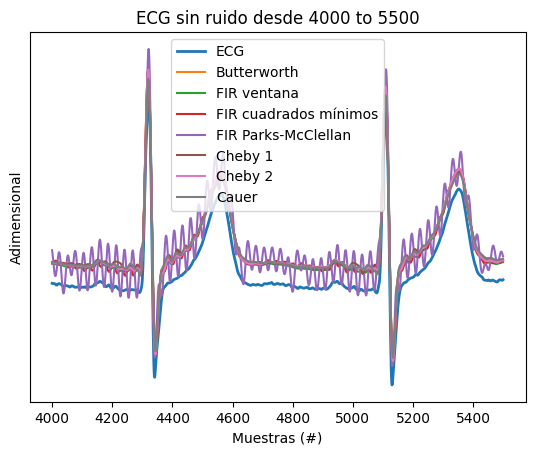

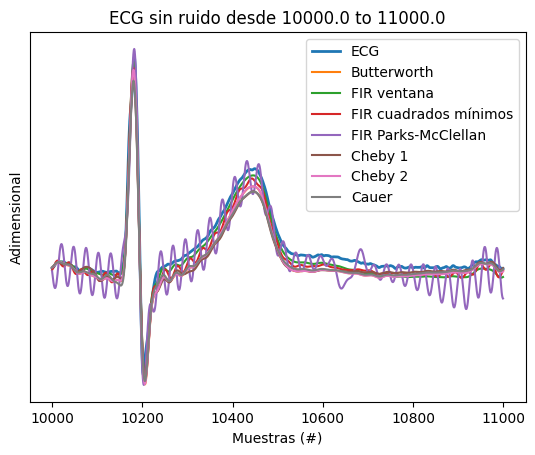

In [59]:
###################################
# Regiones de interés sin ruido #
###################################
 
regs_interes = (
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ecg_filt_butter[zoom_region], label='Butterworth')
    plt.plot(zoom_region, ecg_filt_win[zoom_region + retardo_win], label='FIR ventana')
    plt.plot(zoom_region, ecg_filt_ls[zoom_region + retardo_ls], label='FIR cuadrados mínimos')
    plt.plot(zoom_region, ecg_filt_rem[zoom_region + retardo_rem], label='FIR Parks-McClellan')
    plt.plot(zoom_region, ecg_filt_cheby1[zoom_region], label='Cheby 1')
    plt.plot(zoom_region, ecg_filt_cheby2[zoom_region], label='Cheby 2')
    plt.plot(zoom_region, ecg_filt_cauer[zoom_region], label='Cauer')
    
    plt.title('ECG sin ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Amplitud')
    plt.xlabel('Muestras')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()

La selección de esta región libre de ruido se realizó mediante inspección visual de la señal completa. En este tramo, donde el ECG varía lentamente y no contiene componentes de alta frecuencia, todos los filtros producen un resultado muy similar. Debido a la baja dinámica de la señal, la distorsión de fase pierde relevancia y el comportamiento de los filtros se vuelve casi indistinguible en la forma general.

Aun así, pueden notarse algunas diferencias sutiles:

Los cuatro filtros IIR, al tener respuestas pasa-banda muy ajustadas y órdenes comparables, sus salidas quedan prácticamente superpuestas. Todos suavizan la señal de forma eficiente y sin introducir ondulaciones significativas.

El FIR por ventana es uno de los que produce la salida más suave, prácticamente coincidente con la señal original pero ligeramente más elevada debido a su respuesta de magnitud. No presenta oscilaciones marcadas.

El FIR por cuadrados mínimos mantiene la forma general pero presenta ripple sistemático, visible como pequeñas ondulaciones regulares a lo largo de toda la región. Aunque no afectan la envolvente general, sí generan una textura más rugosa comparada con el resto.

Por último, el FIR Parks-McClellan también sigue muy bien la forma del ECG y funciona correctamente en esta zona lenta, pero se observa que oscila levemente a lo largo de toda la región, característica del diseño equirriple. Aunque la forma global se preserva, la señal filtrada presenta una ondulación continua.


Finalmente, se analizaron regiones de la señal con ruido:

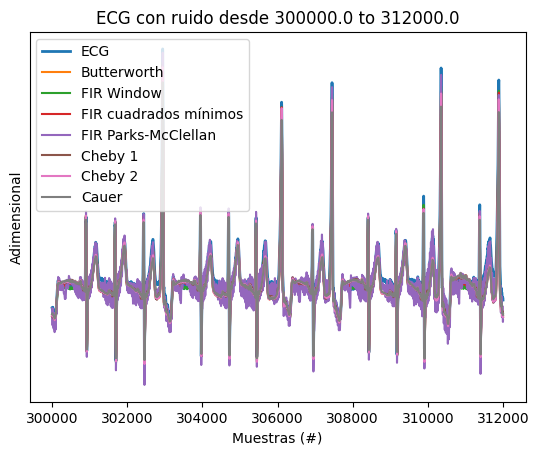

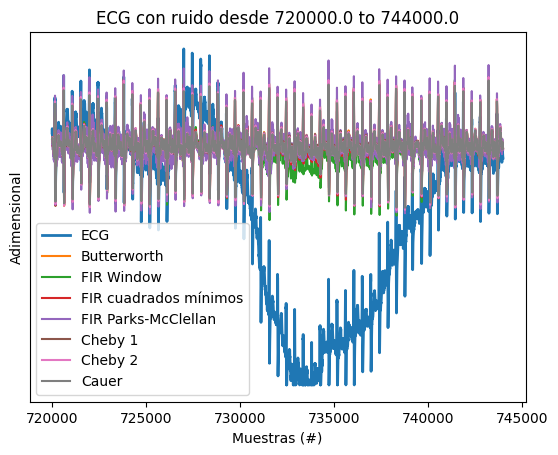

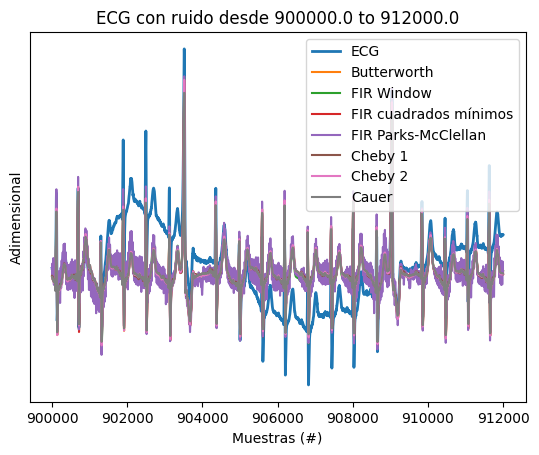

In [60]:
###################################
# Regiones de interés con ruido #
###################################
 
regs_interes = (
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ecg_filt_butter[zoom_region], label='Butterworth')
    plt.plot(zoom_region, ecg_filt_win[zoom_region + retardo_win], label='FIR Window')
    plt.plot(zoom_region, ecg_filt_ls[zoom_region + retardo_ls], label='FIR cuadrados mínimos')
    plt.plot(zoom_region, ecg_filt_rem[zoom_region + retardo_rem], label='FIR Parks-McClellan')
    plt.plot(zoom_region, ecg_filt_cheby1[zoom_region], label='Cheby 1')
    plt.plot(zoom_region, ecg_filt_cheby2[zoom_region], label='Cheby 2')
    plt.plot(zoom_region, ecg_filt_cauer[zoom_region], label='Cauer')
    
    plt.title('ECG con ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Amplitud')
    plt.xlabel('Muestras')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
    
    plt.show()

Al igual que en el caso de las zonas sin ruido, las regiones con ruido fueron seleccionadas mediante inspección visual del registro completo de ECG.

En los distintos segmentos analizados, puede observarse que todos los filtros logran reducir el ruido, aunque con diferencias claras en cuanto a distorsión, ripple y preservación de la morfología.

Realizando una evaluación general del desempeño de cada filtro es posible decir que el Butterworth presenta un comportamiento muy estable y consistente. Atenúa eficazmente el ruido de alta frecuencia sin generar oscilaciones ni ringing. En algunos tramos puede elevar levemente la línea de base, pero en general es uno de los filtros con mejor compromiso entre suavización y preservación de la forma del ECG. El FIR por ventana es el que genera la salida más suavizada, pero a costa de distorsionar más la amplitud. En varios segmentos se “queda corto” en amplitud e incluso aplana componentes importantes del ECG. Tiende a atenuar demasiado picos y transiciones rápidas, por lo que es el que más modifica la morfología. El FIR por mínimos cuadrados ofrece una respuesta suave, con bajo nivel de ruido residual y buena preservación de la forma del QRS y de la onda T. Presenta menos oscilaciones que Parks–McClellan, siendo un diseño equilibrado entre filtrado y fidelidad morfológica. El FIR Parks–McClellan (equirriple) filtra bien pero introduce el ripple característico de este método de diseño. Se observan pequeñas oscilaciones distribuidas a lo largo de toda la señal, especialmente alrededor de los QRS. Aunque no distorsiona severamente la forma, es menos suave que el FIR por mínimos cuadrados o el Butterworth. Los filtros Chebyshev I y II muestran un comportamiento similar: buen nivel de filtrado pero con ripples más marcados, ya sea en banda de paso (Cheby I) o en banda de rechazo (Cheby II). En los flancos del QRS pueden aparecer oscilaciones visibles. Sin embargo, mantienen relativamente bien la amplitud de la señal. Por último, el filtro Cauer (Elíptico) presenta buena atenuación del ruido y transiciones rápidas. Como todo filtro elíptico, puede generar ondulaciones pequeñas, pero globalmente conserva la morfología con bastante eficacia. Su desempeño se ubica entre Butterworth y Chebyshev en términos de compromiso entre suavidad y eficiencia espectral.

Para el gráfico 1: todos los filtros reducen bien el ruido; Parks-McClellan y Chebyshev muestran más oscilaciones; Butterworth y cuadrados mínimos parecen los más "limpios", FIR ventana se queda por debajo en amplitud.

Para el gráfico 2: Butterworth y cuadrados mínimos suavizan sin distorsionar; FIR ventana atenúa demasiado; Chebyshev y Parks-McClellan muestran ripple. 

Para el gráfico 3: con un QRS muy grande los mejores para este filtrado son Butterworth, cuadrados mínimos y Cauer, Chebyshev y Parks-McClellan oscilan y FIR ventana se queda corto en amplitud. 

El filtro Butterworth y el FIR por cuadrados mínimos presentan el mejor compromiso entre reducción de ruido y preservación de la forma del ECG. El FIR con ventana es el que más suaviza pero distorsiona la amplitud. Los filtros Chebyshev y Parks–McClellan introducen oscilaciones (ripples), especialmente alrededor de los QRS. El Cauer ofrece buen filtrado pero con leves ondulaciones típicas de su diseño elíptico.

## Conclusión
El estudio comparativo de los distintos filtros digitales aplicados a un registro de ECG permitió evaluar con precisión cómo cada aproximación (tanto IIR como FIR) afecta la morfología del trazo cardíaco, la supresión del ruido y la preservación de las características clínicas relevantes.

En primer lugar, los filtros IIR mostraron un desempeño consistente y eficiente para este tipo de señal. Entre ellos, el Butterworth se posicionó como el diseño con mejor equilibrio global: suaviza el ruido de alta frecuencia sin introducir ondulaciones adicionales y preserva adecuadamente la forma del QRS y las ondas lentas del ECG. El Chebyshev I y Chebyshev II demostraron mayor selectividad espectral, pero a costa de ondulaciones (ripple) en banda de paso o de rechazo, respectivamente, que pueden manifestarse como oscilaciones visibles alrededor de eventos rápidos. El filtro Cauer, al tener la transición más abrupta, logra excelente atenuación del ruido, aunque presenta ondulaciones pequeñas propias del diseño elíptico.

En cuanto a los filtros FIR, todos mantuvieron la linealidad aproximada de fase y un retardo constante. El diseño mediante ventanas fue el más simple y el que produjo la salida más suavizada, pero también fue el que más distorsionó la amplitud y “aplanó” componentes relevantes del ECG. El FIR de cuadrados mínimos mostró el compromiso más equilibrado: poco ripple, buena preservación del QRS y adecuada reducción del ruido. El método Parks–McClellan, aunque óptimo en sentido minimax, introdujo el ripple equirriple característico, perceptible como pequeñas oscilaciones distribuidas a lo largo de la señal.

En regiones sin ruido, todos los filtros funcionaron correctamente debido a la naturaleza lenta de la señal, aunque se observaron ondulaciones sistemáticas tanto en el FIR de cuadrados mínimos como en el de Parks–McClellan, coherentes con sus criterios de diseño. En presencia de ruido, las diferencias se hicieron más evidentes: Butterworth y cuadrados mínimos sobresalieron como las alternativas más limpias y morfológicamente fieles, mientras que Parks–McClellan, Chebyshev y Cauer fueron más susceptibles a generar ripple en los flancos del QRS. El FIR por ventana, si bien redujo el ruido, alteró significativamente la amplitud del complejo QRS.

En síntesis, los filtros que ofrecieron el mejor compromiso entre supresión del ruido y preservación de la morfología del ECG fueron el Butterworth y el FIR por mínimos cuadrados. Los métodos Chebyshev y Parks–McClellan proporcionan una excelente selectividad, pero al costo de introducir oscilaciones. El filtro Cauer ofrece buena eficiencia espectral, aunque con ondulaciones más marcadas, y el FIR por ventana resulta útil para suavizar, pero no es adecuado cuando la fidelidad de amplitud es prioritaria.

En conjunto, el análisis confirma que no existe un filtro “universalmente superior”, sino que la elección depende del compromiso deseado entre atenuación, ripple y preservación morfológica, siendo Butterworth y cuadrados mínimos los más equilibrados para las condiciones evaluadas.

## Autoevaluación del aprendizaje
Durante este trabajo consolidamos nuestra comprensión del diseño e implementación de filtros digitales aplicados a señales ECG. Pudimos comparar filtros FIR e IIR no solo desde la teoría, sino observando cómo sus características (ripple, suavizado, fase, pendiente de transición) afectan realmente la morfología del QRS y la eliminación del ruido.

Aprendimos a elegir segmentos adecuados para el análisis, a identificar visualmente distorsiones, oscilaciones y pérdidas de amplitud, y a justificar por qué ciertos filtros, como Butterworth o cuadrados mínimos, ofrecen un mejor equilibrio entre limpieza y preservación de la señal, mientras que otros introducen ondulaciones o suavizan en exceso.

En síntesis, este trabajo nos permitió integrar teoría y práctica, mejorar nuestro criterio técnico y comprender mejor cómo seleccionar el filtro adecuado según el tipo de ruido y la parte del ECG que se busca preservar.

Con el objetivo de profundizar en los contenidos teóricos recurrimos a la bibliografía recomendada (*Thomas Holton - Digital Signal Processing*). Utilizamos ChatGPT para algunos comandos de Python con la presentación de los gráficos y la implementación de los filtros, y para reforzar los contenidos teóricos.